In this notebook, transfer learning with VGG16 is tested for it's performance in improving the accuracy of scenery image identification.  
It is a new slice of train and validation images and the epochs are increased to 20.  

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.metrics import classification_report

In [3]:
image_path = "../input/intel-image-classification/seg_train/seg_train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  image_size=(224,224),
  batch_size=32,
validation_split=0.25,
  subset="training",
  seed=223)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  image_size=(224,224),
  batch_size=32,
validation_split=0.25,
  subset="validation",
  seed=223)

test_path = "../input/intel-image-classification/seg_test/seg_test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  image_size=(224,224),
  batch_size=32)

new_test_path = "../input/new-test-dataset/test_images"
new_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_test_path,
  image_size=(224,224),
  batch_size=32)

Found 14034 files belonging to 6 classes.
Using 10526 files for training.
Found 14034 files belonging to 6 classes.
Using 3508 files for validation.
Found 3000 files belonging to 6 classes.
Found 37 files belonging to 6 classes.


In [4]:
import glob
import pathlib 

data_dir = pathlib.Path(image_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


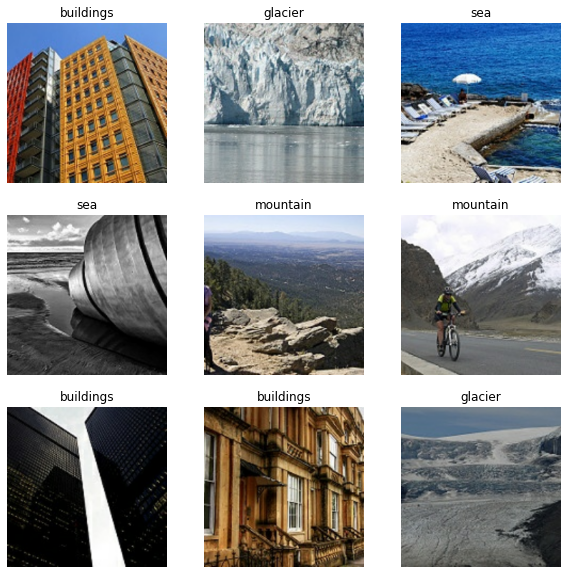

In [5]:
## visualize train set images
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

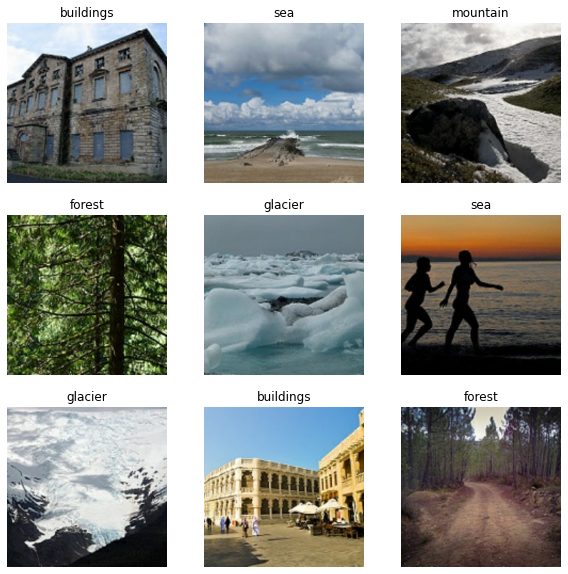

In [6]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

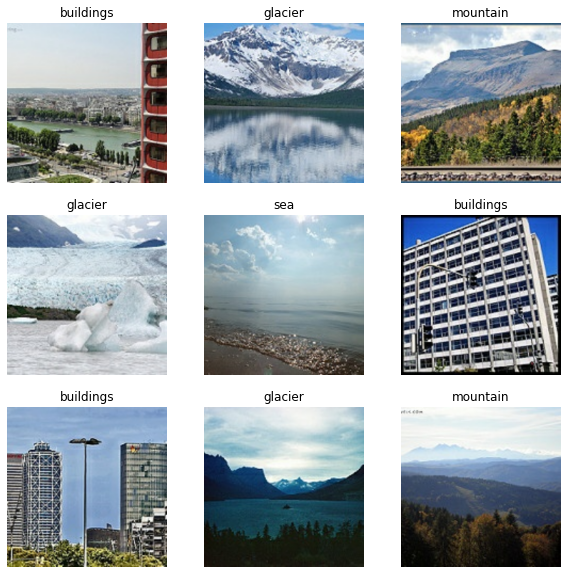

In [8]:
## visualize test images 
image_batch, label_batch = next(iter(test_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

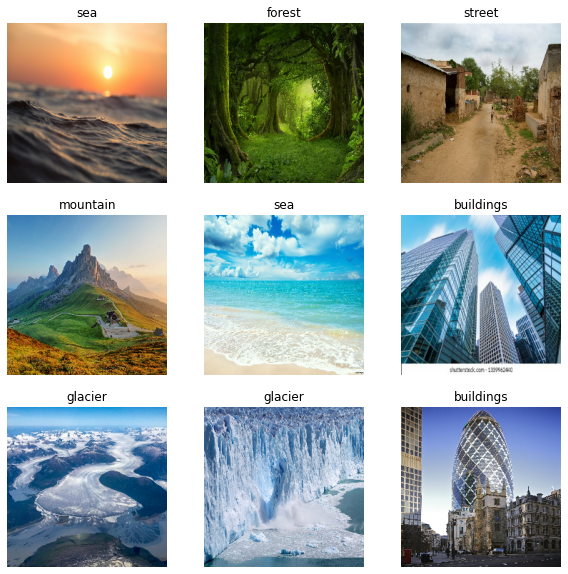

In [9]:
## visualize new test images 
image_batch, label_batch = next(iter(new_test_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

In [10]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img , (224,224))
        if img is not None:
            images.append(img)
    return images

pred_images = load_images_from_folder("../input/intel-image-classification/seg_pred/seg_pred")

In [11]:
type(pred_images)

list

In [12]:
pred_images = np.array(pred_images)
pred_images.shape

(7301, 224, 224, 3)

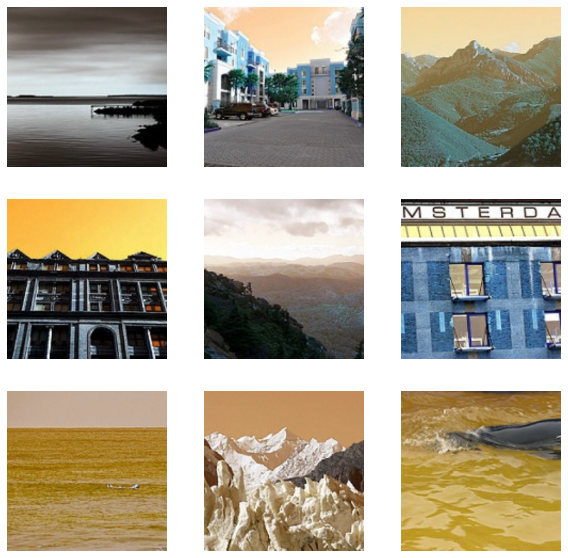

In [13]:
## visualize prediction images 
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(pred_images[i])
    plt.axis("off")

58892288/58889256 [==============================] - 0s 0us/step: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________
CPU times: user 35min 18s, sys: 29min 23s, total: 1h 4min 42s
Wall time: 8h 30min 32s
94/94 [==============================] - 357s 4s/step - loss: 0.4502 - accuracy: 0.8550
Test image accuracy :0.8550000190734863
2/2 [==============================] - 8s 3s/step - loss: 1.3814 - accuracy: 0.5135
Test 

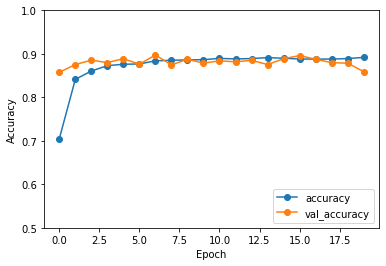

In [14]:
# Transfer learning with VGG16 . 
base_Net = tf.keras.applications.VGG16(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dropout(0.2))
model_Net.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds, validation_data = val_ds, epochs = 20, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds)
print("Test image accuracy :{}".format(test_acc))
##
new_test_loss, new_test_acc = model_Net.evaluate(new_test_ds)
print("Test image accuracy :{}".format(new_test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_Net')

In [ ]:
## for test data set , check the classification report.
val_pred = np.array([])
val_labels = np.array([])
for x, y in test_ds:
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    val_pred = np.concatenate([val_pred,np.array(predictions)])
    val_labels = np.concatenate([val_labels , y.numpy()])
    
##
print('Classification Report for test ds')
target_names = class_names
print(classification_report(val_labels, val_pred, target_names=class_names))
##
## for new test data set , check the classification report.
new_val_pred = np.array([])
new_val_labels = np.array([])
for x, y in new_test_ds:
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    new_val_pred = np.concatenate([new_val_pred,np.array(predictions)])
    new_val_labels = np.concatenate([new_val_labels , y.numpy()])
    
##
print('Classification Report for new test ds')
target_names = class_names
print(classification_report(new_val_labels, new_val_pred, target_names=class_names))
##
##
pred_images_prediction = model_Net.predict(pred_images)
##
pred_images_class = []
for i in range(len(pred_images_prediction)):
    pred_images_class.append(np.argmax(pred_images_prediction[i], axis = -1))
##
## visualize prediction images with the prediction 
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(pred_images[i])
    plt.title(class_names[pred_images_class[i]])
    plt.axis("off")

Classification Report for test ds
              precision    recall  f1-score   support

   buildings       0.77      0.97      0.86       437
      forest       1.00      0.97      0.99       474
     glacier       0.78      0.84      0.81       553
    mountain       0.87      0.66      0.75       525
         sea       0.81      0.96      0.88       510
      street       0.98      0.74      0.84       501

    accuracy                           0.85      3000
   macro avg       0.87      0.86      0.85      3000
weighted avg       0.86      0.85      0.85      3000

Classification Report for new test ds
              precision    recall  f1-score   support

   buildings       0.86      1.00      0.92         6
      forest       1.00      1.00      1.00         5
     glacier       0.67      0.67      0.67         6
    mountain       1.00      0.67      0.80         6
         sea       0.78      1.00      0.88         7
      street       1.00      0.86      0.92         7

    a

The session ended before completing the previous cell. How ever , it computed the accuracy and its 0.85 for test set.  